In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
%matplotlib inline

In [118]:
df = pd.read_csv('GBvideos_cc50_202101.csv')


In [119]:
df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,state,lat,lon,geometry
0,Jw1Y-zhQURU,17.14.11,John Lewis Christmas Ad 2017 - #MozTheMonster,John Lewis,26,2017-11-10T07:38:29.000Z,"christmas|""john lewis christmas""|""john lewis""|...",7224515,55681,10247,9479,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg,False,False,False,Click here to continue the story and make your...,Devon,50.700405,-3.529950,POINT (-3.529950197 50.70040529)
1,3s1rvMFUweQ,17.14.11,Taylor Swift: …Ready for It? (Live) - SNL,Saturday Night Live,24,2017-11-12T06:24:44.000Z,"SNL|""Saturday Night Live""|""SNL Season 43""|""Epi...",1053632,25561,2294,2757,https://i.ytimg.com/vi/3s1rvMFUweQ/default.jpg,False,False,False,Musical guest Taylor Swift performs …Ready for...,Manchester,53.500415,-2.247987,POINT (-2.247987103 53.50041526)
2,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787420,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...,Bath And North East Somerset,51.383749,-2.350022,POINT (-2.350022218 51.3837486)
3,PUTEiSjKwJU,17.14.11,Goals from Salford City vs Class of 92 and Fri...,Salford City Football Club,17,2017-11-13T02:30:38.000Z,"Salford City FC|""Salford City""|""Salford""|""Clas...",27833,193,12,37,https://i.ytimg.com/vi/PUTEiSjKwJU/default.jpg,False,False,False,Salford drew 4-4 against the Class of 92 and F...,Aberdeen,57.170398,-2.079987,POINT (-2.079987021 57.17039797)
4,rHwDegptbI4,17.14.11,Dashcam captures truck's near miss with child ...,Cute Girl Videos,25,2017-11-13T01:45:13.000Z,[none],9815,30,2,30,https://i.ytimg.com/vi/rHwDegptbI4/default.jpg,False,False,False,Dashcam captures truck's near miss with child ...,Southampton,50.900031,-1.399977,POINT (-1.399976849 50.90003135)


In [120]:
# Estructura de los datos
df.dtypes

video_id                   object
trending_date              object
title                      object
channel_title              object
category_id                 int64
publish_time               object
tags                       object
views                       int64
likes                       int64
dislikes                    int64
comment_count               int64
thumbnail_link             object
comments_disabled            bool
ratings_disabled             bool
video_error_or_removed       bool
description                object
state                      object
lat                       float64
lon                       float64
geometry                   object
dtype: object

In [121]:
#Eliminamos las columnas que no usaremos para nuestra predicción
df = df.drop(columns=['lat','lon','tags', 'thumbnail_link','comments_disabled','ratings_disabled','video_error_or_removed','video_error_or_removed','description','state','geometry','video_id','trending_date','channel_title','title'])

print(df.shape)

(38916, 6)


In [122]:
import json

with open('GB_category_id.json') as f:
    data = json.load(f)

category_dict_json = {int(item['id']): item['snippet']['title'] for item in data['items']}

df['category_name'] = df['category_id'].map(category_dict_json)

print(df[['category_id', 'category_name']].head(10))

   category_id    category_name
0           26    Howto & Style
1           24    Entertainment
2           10            Music
3           17           Sports
4           25  News & Politics
5           24    Entertainment
6           10            Music
7           22   People & Blogs
8           10            Music
9           10            Music


In [123]:
#El formato de publish_time esta en un formato que no nos conviene asi que lo separamos en publish_day y publish_time
df['publish_time'] = pd.to_datetime(df['publish_time'], errors='coerce')
df['publish_day'] = df['publish_time'].dt.day_name()
df['publish_hour'] = df['publish_time'].dt.hour

In [124]:
# Crear un mapeo para los días de la semana
day_mapping = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}

df['publish_time'] = pd.to_datetime(df['publish_time'])
df['publish_day'] = df['publish_day'].map(day_mapping)
df['publish_hour'] = df['publish_time'].dt.hour

df.head()

,category_id,publish_time,views,likes,dislikes,comment_count,category_name,publish_day,publish_hour
0,26,2017-11-10 07:38:29+00:00,7224515,55681,10247,9479,Howto & Style,5,7
1,24,2017-11-12 06:24:44+00:00,1053632,25561,2294,2757,Entertainment,7,6
2,10,2017-11-10 17:00:03+00:00,17158579,787420,43420,125882,Music,5,17
3,17,2017-11-13 02:30:38+00:00,27833,193,12,37,Sports,1,2
4,25,2017-11-13 01:45:13+00:00,9815,30,2,30,News & Politics,1,1


In [125]:
df = df.drop(columns=['publish_time'])
df.head()


,category_id,views,likes,dislikes,comment_count,category_name,publish_day,publish_hour
0,26,7224515,55681,10247,9479,Howto & Style,5,7
1,24,1053632,25561,2294,2757,Entertainment,7,6
2,10,17158579,787420,43420,125882,Music,5,17
3,17,27833,193,12,37,Sports,1,2
4,25,9815,30,2,30,News & Politics,1,1


<Axes: >

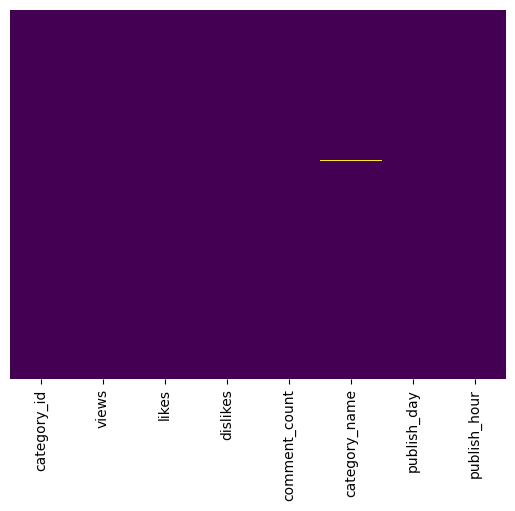

In [126]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [127]:
# Número de datos ausentes por variable
df.isna().sum().sort_values()

category_id       0
views             0
likes             0
dislikes          0
comment_count     0
publish_day       0
publish_hour      0
category_name    90
dtype: int64

In [128]:
#Imputar variables
for column in ['views','publish_hour', 'publish_day', 'likes', 'dislikes', 'comment_count']:
    df[column] = df[column].fillna(df[column].mode()[0]) 

df.isna().sum().sort_values()

category_id       0
views             0
likes             0
dislikes          0
comment_count     0
publish_day       0
publish_hour      0
category_name    90
dtype: int64

In [129]:
df.head()

,category_id,views,likes,dislikes,comment_count,category_name,publish_day,publish_hour
0,26,7224515,55681,10247,9479,Howto & Style,5,7
1,24,1053632,25561,2294,2757,Entertainment,7,6
2,10,17158579,787420,43420,125882,Music,5,17
3,17,27833,193,12,37,Sports,1,2
4,25,9815,30,2,30,News & Politics,1,1


#### Variables Cualitativas

In [130]:
categoricas = df.select_dtypes(include=['object','category'])

In [131]:
# Variables cualitativas (tipo object)
# ==============================================================================
categoricas.describe()

,category_name
count,38826
unique,15
top,Music
freq,13754


In [132]:
#Imputar variables
for column in categoricas:
    df[column] = df[column].fillna(df[column].mode()[0]) 

#### Variables Numéricas


In [133]:
## Calcula los porcentajes de missings por variable

def fx_porc_missings(data, only_missings = False):

    df_vars_missings = pd.concat([pd.DataFrame(data.isnull().sum(), columns = ['n_nulos']),
           pd.DataFrame(100*data.isnull().sum()/len(data), columns = ['%Total'])], axis = 1)
    if only_missings:
        return(df_vars_missings[df_vars_missings["n_nulos"]!=0])
    else:
        return(df_vars_missings) 

In [134]:
numericas= df.select_dtypes(include=['float64', 'int'])
numericas.describe()

,category_id,views,likes,dislikes,comment_count,publish_day,publish_hour
count,38916.000000,3.891600e+04,3.891600e+04,3.891600e+04,3.891600e+04,38916.000000,38916.000000
mean,16.827937,5.911944e+06,1.345196e+05,7.612560e+03,1.308835e+04,3.583282,12.936093
std,7.752728,1.900121e+07,3.499893e+05,5.095683e+04,5.066740e+04,1.745382,6.446343
min,1.000000,8.510000e+02,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,0.000000
25%,10.000000,2.515272e+05,5.897000e+03,2.000000e+02,6.790000e+02,2.000000,8.000000
50%,20.000000,9.818890e+05,2.518250e+04,8.210000e+02,2.478000e+03,4.000000,15.000000
75%,24.000000,3.683628e+06,1.140892e+05,3.357500e+03,9.241500e+03,5.000000,18.000000
max,43.000000,4.245389e+08,5.613827e+06,1.944971e+06,1.626501e+06,7.000000,23.000000


In [135]:
## Missing de Variables
variables_perdidos = fx_porc_missings(numericas, only_missings = True)    
#variables_perdidos.head()
variables_perdidos

,n_nulos,%Total



### Limpiando los datos

In [ ]:
# plt.figure(figsize=(12, 7))
# sns.boxplot(x='likes',y='views',data=df,palette='winter')

### Modelado

In [ ]:
X = df.drop(['views'], axis = 1)

In [ ]:
y= df.views

In [ ]:
categoricas = X.select_dtypes(include=('object','category')).columns.tolist()
numericas = X.select_dtypes(include=('int64','float64')).columns.tolist()

## Conversión de características categóricas


In [ ]:
## Cantidad de Categorías por Variable
variables_str  = X.select_dtypes(include = ['object','category']).columns.tolist()
for var in variables_str:
    print('N de ', var,':',df[var].nunique())

N de  category_name : 15


In [ ]:
categorical=pd.get_dummies(X[categoricas],columns=categoricas,drop_first=True)
# categorical.columns = ['category_id']
categorical.head()

,category_name_Comedy,category_name_Education,category_name_Entertainment,category_name_Film & Animation,category_name_Gaming,category_name_Howto & Style,category_name_Music,category_name_News & Politics,category_name_People & Blogs,category_name_Pets & Animals,category_name_Science & Technology,category_name_Shows,category_name_Sports,category_name_Travel & Events
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0


### Conversión de variables numéricas

In [142]:
numericas


,category_id,views,likes,dislikes,comment_count,publish_day,publish_hour
0,26,7224515,55681,10247,9479,5,7
1,24,1053632,25561,2294,2757,7,6
2,10,17158579,787420,43420,125882,5,17
3,17,27833,193,12,37,1,2
4,25,9815,30,2,30,1,1
...,...,...,...,...,...,...,...
38911,10,25066952,268088,12783,9933,3,7
38912,10,1492219,61998,13781,24330,5,17
38913,10,29641412,394830,8892,19988,2,11
38914,24,14317515,151870,45875,26766,2,20


In [ ]:
scaler = StandardScaler()
numerical = X[numericas]
numerical = pd.DataFrame(scaler.fit_transform(numerical),
                         columns=['likes', 'dislikes', 'comment_count', 'publish_day', 'publish_hour'],index= numerical.index)

In [ ]:
preprocessed_data = pd.merge(numerical, categorical, left_index=True, right_index=True)
preprocessed_data.head()

,likes,dislikes,comment_count,publish_day,publish_hour,category_id_10,category_id_15,category_id_17,category_id_19,category_id_2,...,category_id_POINT (-4.61667973 55.4503996),category_id_POINT (-4.750030763 55.93329002),category_id_POINT (-5.112075806 56.81647795),category_id_POINT (-5.550033611 50.13372154),category_id_POINT (-6.670016929 54.52037884),category_id_POINT (-7.300004315 54.60001223),category_id_POINT (0.71999711 51.55001752),category_id_POINT (1.169995482 52.07034751),category_id_POINT (1.300013386 51.13371218),category_id_POINT (1.300013386 52.63036501)
0,-0.225119,0.078534,-0.071655,0.809168,-0.925381,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.311084,-0.117426,-0.225749,1.959171,-1.081020,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.863344,0.895909,2.596755,0.809168,0.631011,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.383487,-0.173654,-0.288102,-1.490839,-1.703577,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.383953,-0.173901,-0.288263,-1.490839,-1.859216,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Construyendo un modelo de regresión logística


## Dividir el dataset en train y test


In [137]:
from sklearn.model_selection import train_test_split

In [ ]:
# División de los datos en train y test
X_train, X_test, y_train, y_test = train_test_split(preprocessed_data, y, train_size=0.7, random_state=20)


## Entrenamiento y predicción

In [139]:
from sklearn.linear_model import LogisticRegression

In [140]:

logmodel = LogisticRegression(solver='lbfgs', max_iter=1000) #Parametros utilizados para problemas con multiclases

In [ ]:
# Entrenamiento del modelo
logmodel.fit(X_train,y_train)

In [ ]:
# Predecir con el algoritmo entrenado para validar
y_pred_train=logmodel.predict(X_train) # Prediccion sobre el train
y_pred_test=logmodel.predict(X_test) # Prediccion sobre el test

In [ ]:
# Calculando probabilidades para la muestra testdel modelo
prob_test_rl = logmodel.predict_proba(X_test)[:,1]
plt.hist(prob_test_rl, color = '#ea068d', rwidth=0.9)
plt.savefig('Probabilidades_logreg.png', bbox_inches='tight')

In [ ]:
# Calculando las probabilidades para la muestra de entrenamiento
prob_train_rl = logmodel.predict_proba(X_train)[:,1]
plt.hist(prob_train_rl, color = '#ff74c6', rwidth=0.9)
plt.savefig('Probabilidades_train_logreg.png', bbox_inches='tight')

## Evaluación

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
predictions = logmodel.predict(X_test)

In [ ]:
print(classification_report(y_test,predictions))

### Matriz de confusión

In [ ]:
mat_logreg = confusion_matrix(y_test, y_pred_test)
sns.heatmap(mat_logreg, annot=True, fmt='d',cmap='nipy_spectral', square=True, cbar=False, annot_kws = {'size' : 20})
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('Confusion_matrix_logreg.png', bbox_inches='tight')

#### Curva ROC

In [ ]:
## AUC: Area bajo la curva
auc_rl = metrics.roc_auc_score(y_test, prob_test_rl)
auc_rl

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, prob_test_rl)
plt.plot(fpr, tpr, label= "AUC = " + str(auc_rl.round(3)), color='#ea068d')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC CURVE and AUC for Logistic Regression')
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate')
plt.legend(bbox_to_anchor=(.5,-0.23), loc='upper center')
plt.savefig('ROC_CURVES_logreg.png', bbox_inches='tight')


### Resultados del Modelo

In [ ]:
# Asignamos las probabilidades a los datos transformados
probabilidad = list(prob_test_rl.round(3))
probabilidad_train = list(prob_train_rl.round(3))
X_test['PROBABILIDAD'] = probabilidad
X_train['PROBABILIDAD'] = probabilidad_train

# Ordenamos de mayor a menor las probabilidades
X_train = X_train.sort_values(['PROBABILIDAD'], ascending=False)
X_test = X_test.sort_values(['PROBABILIDAD'], ascending=False)

In [ ]:
# Creamos grupos de probabilidad para la muestra de entrenamiento
X_train['GRUPOS'] = pd.qcut(X_train['PROBABILIDAD'], 10, labels=[10,9,8,7,6,5,4,3,2,1])

In [ ]:
# Creamos grupos de probabilidad para la muestra de validación
X_test['GRUPOS'] = pd.qcut(X_test['PROBABILIDAD'], 10, labels=[10,9,8,7,6,5,4,3,2,1])

In [ ]:
# Añadimos los identificadores de clientes
final_train = X_train.merge(df_index, how='left', left_index=True, right_index=True, sort=False)
final_test = X_test.merge(df_index, how='left', left_index=True, right_index=True, sort=False)

In [ ]:
final_train.head()